In [1]:
# !pip install transformers
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, GRU, LSTM
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow as tf
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

2024-03-11 16:58:53.635156: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-11 16:58:53.682411: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 16:58:53.682446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 16:58:53.683695: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-11 16:58:53.693471: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the second GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

2 Physical GPU, 1 Logical GPU


2024-03-11 16:59:25.764316: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14408 MB memory:  -> device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:af:00.0, compute capability: 8.6


In [3]:
def load_data(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

data = load_data("/Dataset1-NamedEntityRecognition_train.json")

texts = [data[key]["text"] for key in data]
words = [sentence.split() for sentence in texts]
nested_labels = [data[key]["labels"] for key in data]

In [4]:
def load_glove_embeddings(glove_file, embedding_dim):
    """Loads pre-trained GloVe word embeddings from a file.
    Returns: dict: A dictionary mapping words to their corresponding embedding vectors.
             np.ndarray: An embedding matrix with rows representing words and columns representing dimensions.
    """
    embeddings_index = {}
    embedding_matrix = np.zeros((len(word_to_id) + 1, embedding_dim))  # Add 1 for padding

    with open(glove_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    for word, index in word_to_id.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
        else:
            embedding_matrix[index] = np.zeros(embedding_dim)

    return embeddings_index, embedding_matrix

# Replace with your downloaded GloVe file path and desired dimensionality
glove_file = "glove.6B.100d.txt"
embedding_dim = 100

# Create a dictionary mapping words to their unique IDs (optional for vectorization)
word_to_id = {}
next_id = 1
for sentence in words:  # Iterate through sentences in the nested list
    for word in sentence:
        if word not in word_to_id:
            word_to_id[word] = next_id
            next_id += 1

# Load the GloVe embeddings
embeddings_index, embedding_matrix = load_glove_embeddings(glove_file, embedding_dim)

# Vectorization of words
word_embeddings = []
for sentence in words:
    sentence_embedding = []
    for word in sentence:
        vector = embeddings_index.get(word)
        if vector is not None:
            sentence_embedding.append(vector)
        else:
            sentence_embedding.append(np.zeros(100)) # dimension of the glove file used.
    word_embeddings.append(sentence_embedding)

for sentence in word_embeddings:
    sentence_length = len(sentence)
    if sentence_length < 70: #max length of sentence = 70
        while len(sentence) < 70:
            sentence.append(np.zeros(100))     

# padding to convert into (9435, 70, 100)  from (9435, variable_length, 70)           
for i in range(len(word_embeddings)):
    word_embeddings[i] = np.array(word_embeddings[i])
word_embeddings = np.array(word_embeddings)
word_embeddings.shape 

(9435, 70, 100)

In [6]:
flat_labels = [label for sublist in nested_labels for label in sublist]

# Find unique labels
unique_labels = set(flat_labels)

print(unique_labels)

label2idx = {label: idx for idx, label in enumerate(unique_labels)}
labels_idx = [[label2idx[label] for label in sublist] for sublist in nested_labels]

# One-hot encode labels
num_classes = len(unique_labels)
one_hot_labels = [to_categorical(sublist, num_classes=num_classes) for sublist in labels_idx]

def convert_to_list(lst):
    if isinstance(lst, np.ndarray):
        return lst.tolist()
    elif isinstance(lst, list):
        return [convert_to_list(item) for item in lst]
    else:
        return lst
one_hot_labels = convert_to_list(one_hot_labels)

{'I_ORG', 'B_WITNESS', 'B_STATUTE', 'B_PRECEDENT', 'I_JUDGE', 'I_GPE', 'I_DATE', 'B_DATE', 'B_ORG', 'I_COURT', 'B_RESPONDENT', 'B_GPE', 'I_CASE_NUMBER', 'I_WITNESS', 'I_RESPONDENT', 'B_PETITIONER', 'B_PROVISION', 'B_JUDGE', 'I_PETITIONER', 'B_OTHER_PERSON', 'I_PRECEDENT', 'I_STATUTE', 'I_PROVISION', 'O', 'B_CASE_NUMBER', 'I_OTHER_PERSON', 'B_COURT'}


In [7]:
print(label2idx)

{'I_ORG': 0, 'B_WITNESS': 1, 'B_STATUTE': 2, 'B_PRECEDENT': 3, 'I_JUDGE': 4, 'I_GPE': 5, 'I_DATE': 6, 'B_DATE': 7, 'B_ORG': 8, 'I_COURT': 9, 'B_RESPONDENT': 10, 'B_GPE': 11, 'I_CASE_NUMBER': 12, 'I_WITNESS': 13, 'I_RESPONDENT': 14, 'B_PETITIONER': 15, 'B_PROVISION': 16, 'B_JUDGE': 17, 'I_PETITIONER': 18, 'B_OTHER_PERSON': 19, 'I_PRECEDENT': 20, 'I_STATUTE': 21, 'I_PROVISION': 22, 'O': 23, 'B_CASE_NUMBER': 24, 'I_OTHER_PERSON': 25, 'B_COURT': 26}


In [8]:
for sentence in one_hot_labels:
    sentence_length = len(sentence)
    if sentence_length < 70: #max length of sentence = 70
        while len(sentence) < 70:
            sentence.append([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

one_hot_labels = np.array(one_hot_labels)
one_hot_labels.shape

(9435, 70, 27)

2024-03-11 17:08:17.116416: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-11 17:08:20.050416: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-11 17:08:20.272719: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0ebc91e1c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-11 17:08:20.272757: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-03-11 17:08:20.280934: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710176900.454182 1384342 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 [==============================] - 0s 8ms/step
Epoch 1: Training Macro-F1-score: 0.056773432326856214, Validation Macro-F1-score: 0.055064779427425346
Epoch 1: Training Accuracy: 0.9246272444725037, Validation Accuracy: 0.9288135766983032
45/45 [==============================] - 0s 8ms/step
Epoch 2: Training Macro-F1-score: 0.09943668107492397, Validation Macro-F1-score: 0.0984737751294421
Epoch 2: Training Accuracy: 0.9356617331504822, Validation Accuracy: 0.9332829117774963
45/45 [==============================] - 0s 8ms/step
Epoch 3: Training Macro-F1-score: 0.17364278400817015, Validation Macro-F1-score: 0.1631841009852091
Epoch 3: Training Accuracy: 0.9403363466262817, Validation Accuracy: 0.9375907778739929
45/45 [==============================] - 0s 8ms/step
Epoch 4: Training Macro-F1-score: 0.235036357864853, Validation Macro-F1-score: 0.2233683574826507
Epoch 4: Training Accuracy: 0.9434022903442383, Validation Accuracy: 0.9399112462997437
45/45 [========================

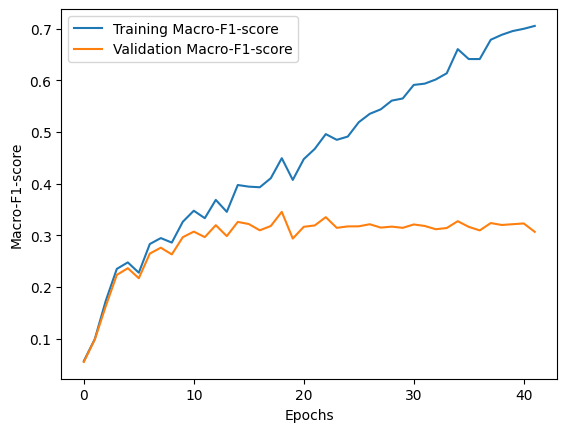

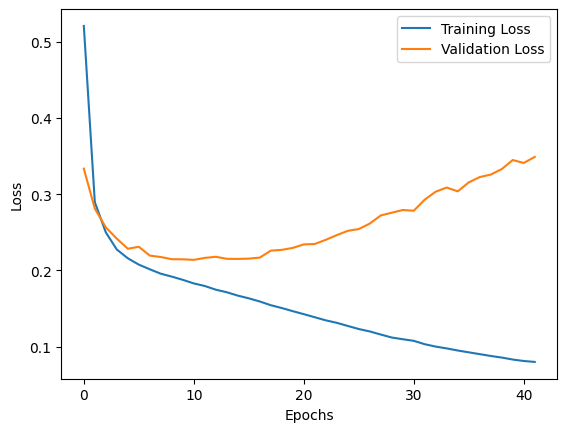

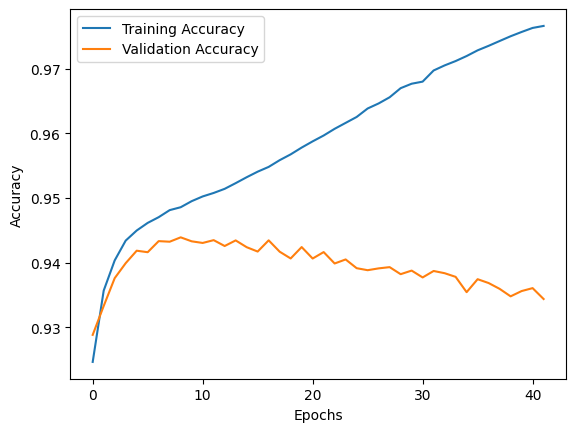

In [9]:
# 1. Prepare the data (already padded)
X_train_padded = word_embeddings  # Assuming padded word embeddings
y_train_padded = one_hot_labels     # Assuming padded labels

# Split into training and validation sets (85-15 split)
split = int(0.85 * len(X_train_padded))
X_train, X_val = X_train_padded[:split], X_train_padded[split:]
y_train, y_val = y_train_padded[:split], y_train_padded[split:]

# 2. Define the RNN model architecture
model = tf.keras.Sequential([
    tf.keras.layers.GRU(units=128, return_sequences=True, input_shape=(70, 100)),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(27, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model and Initialize lists to store F1-score values
train_f1_scores = []
val_f1_scores = []
train_losses = []
val_losses = []
train_acc = []
val_acc = []

train_f1_scores_per_label = []
val_f1_scores_per_label = []

for epoch in range(42):
    # Perform one epoch of training
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=True, validation_data=(X_val, y_val))

    # Get predictions for training and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert one-hot encoded labels back to integer labels
    y_train_true = np.argmax(y_train, axis=-1)
    y_val_true = np.argmax(y_val, axis=-1)

    # Calculate F1-score for training and validation data
    train_f1 = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average='macro')
    val_f1 = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average='macro')

    train_f1_per_label = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average=None)
    val_f1_per_label = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average=None)
    
    # Append F1-score values to lists
    train_f1_scores_per_label.append(train_f1_per_label)
    val_f1_scores_per_label.append(val_f1_per_label)
    
    # Append F1-score values to lists
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    # Append losses to lists
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Append accuracy to lists
    train_acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])

    # Print F1-score and accuracy for each epoch
    print(f'Epoch {epoch + 1}: Training Macro-F1-score: {train_f1}, Validation Macro-F1-score: {val_f1}')
    print(f'Epoch {epoch + 1}: Training Accuracy: {history.history["accuracy"][-1]}, Validation Accuracy: {history.history["val_accuracy"][-1]}')

# Plot F1-score
plt.plot(train_f1_scores, label='Training Macro-F1-score')
plt.plot(val_f1_scores, label='Validation Macro-F1-score')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1-score')
plt.legend()
plt.savefig('/task_1_glove_vec_GRU_f1_score.png')  # Save F1-score figure
plt.show()

# Plot Loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/task_1_glove_GRU_loss.png')  # Save loss figure
plt.show()

# Plot Accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/task_1_glove_GRU_accuracy.png')  # Save accuracy figure
plt.show()


In [ ]:
model.save('/GRU_glove_Dataset1.keras')

## Test Data

In [17]:
# test data
def load_data(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

data2 = load_data("/Dataset1-NamedEntityRecognition_test.json")

texts2 = [data2[key]["text"] for key in data2]
labels = [sentence.split() for sentence in texts2]
words2 = [data2[key]["labels"] for key in data2]

# %%
def load_glove_embeddings(glove_file, embedding_dim):
    """Loads pre-trained GloVe word embeddings from a file.
    Returns: dict: A dictionary mapping words to their corresponding embedding vectors.
             np.ndarray: An embedding matrix with rows representing words and columns representing dimensions.
    """
    embeddings_index = {}
    embedding_matrix = np.zeros((len(word_to_id) + 1, embedding_dim))  # Add 1 for padding

    with open(glove_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    for word, index in word_to_id.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
        else:
            embedding_matrix[index] = np.zeros(embedding_dim)

    return embeddings_index, embedding_matrix

# Replace with your downloaded GloVe file path and desired dimensionality
glove_file = "glove.6B.100d.txt"  # Example: glove.6B.100d.txt
embedding_dim = 100

# Create a dictionary mapping words to their unique IDs (optional for vectorization)
word_to_id = {}
next_id = 1
for sentence in words2:  # Iterate through sentences in the nested list
    for word in sentence:
        if word not in word_to_id:
            word_to_id[word] = next_id
            next_id += 1

# Load the GloVe embeddings
embeddings_index, embedding_matrix = load_glove_embeddings(glove_file, embedding_dim)


# %%
# find the maxlength of the sentence
max_length = max([len(i) for i in words2])
max_length

# %%
# Vectorization of words
word_embeddings2 = []
for sentence in words2:
    sentence_embedding = []
    for word in sentence:
        vector = embeddings_index.get(word)
        if vector is not None:
            sentence_embedding.append(vector)
        else:
            sentence_embedding.append(np.zeros(100)) # dimension of the glove file used.
    word_embeddings2.append(sentence_embedding)

# %%
for sentence in word_embeddings2:
    sentence_length = len(sentence)
    if sentence_length < 70: #max length of sentence = 70
        while len(sentence) < 70:
            sentence.append(np.zeros(100))     

# padding to convert into (9435, 70, 100)  from (9435, variable_length, 70)           
for i in range(len(word_embeddings2)):
    word_embeddings2[i] = np.array(word_embeddings2[i])
word_embeddings2 = np.array(word_embeddings2)
word_embeddings2.shape 



(949, 70, 100)

In [ ]:
labels_idx_test = [[label2idx[label] for label in sublist] for sublist in words2]

one_hot_labels_test = [to_categorical(sublist, num_classes=27) for sublist in labels_idx_test]

# %%
def convert_to_list(lst):
    if isinstance(lst, np.ndarray):
        return lst.tolist()
    elif isinstance(lst, list):
        return [convert_to_list(item) for item in lst]
    else:
        return lst
one_hot_labels_test = convert_to_list(one_hot_labels_test)
# labels_idx[0]

for sentence in one_hot_labels_test:
    sentence_length = len(sentence)
    if sentence_length < 70: #max length of sentence = 70
        while len(sentence) < 70:
            sentence.append([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

one_hot_labels_test = np.array(one_hot_labels_test)
one_hot_labels_test.shape


# %%
X_test_padded = word_embeddings2
y_test_padded = one_hot_labels_test

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test_padded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


y_pred = model.predict(X_test_padded)
# Assuming y_pred contains continuous values, convert them to class labels
y_pred_classes = np.argmax(y_pred, axis=2).flatten()
y_test_classes = np.argmax(y_test_padded, axis=2).flatten()
target_names = [str(label) for label in unique_labels]
# target_names = [str(label) for label in range(27)]  # Assuming you have 27 unique labels
# Generate the classification report using true target values and predicted target values
report = classification_report(y_test_classes, y_pred_classes, target_names=target_names)
print(report)


# Dataset2

In [7]:
def load_data(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data
data2 = load_data("Dataset2-AspectTermExtraction_train.json")

texts2 = [i['text'] for i in data2]
labels = [i['labels'] for i in data2]
words2 = [sentence.split() for sentence in texts2]

In [8]:
# find the maxlength of the sentence
max_length = max([len(i) for i in words2])
max_length

78

In [9]:
def load_glove_embeddings(glove_file, embedding_dim):
    """Loads pre-trained GloVe word embeddings from a file.
    Returns: dict: A dictionary mapping words to their corresponding embedding vectors.
             np.ndarray: An embedding matrix with rows representing words and columns representing dimensions.
    """
    embeddings_index = {}
    embedding_matrix = np.zeros((len(word_to_id) + 1, embedding_dim))  # Add 1 for padding

    with open(glove_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    for word, index in word_to_id.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
        else:
            embedding_matrix[index] = np.zeros(embedding_dim)

    return embeddings_index, embedding_matrix

# Replace with your downloaded GloVe file path and desired dimensionality
glove_file = "glove.6B.100d.txt"  # Example: glove.6B.100d.txt
embedding_dim = 100

# Create a dictionary mapping words to their unique IDs (optional for vectorization)
word_to_id = {}
next_id = 1
for sentence in words2:  # Iterate through sentences in the nested list
    for word in sentence:
        if word not in word_to_id:
            word_to_id[word] = next_id
            next_id += 1

# Load the GloVe embeddings
embeddings_index, embedding_matrix = load_glove_embeddings(glove_file, embedding_dim)


In [10]:
# Vectorization of words
word_embeddings2 = []
for sentence in words2:
    sentence_embedding = []
    for word in sentence:
        vector = embeddings_index.get(word)
        if vector is not None:
            sentence_embedding.append(vector)
        else:
            sentence_embedding.append(np.zeros(100)) # dimension of the glove file used.
    word_embeddings2.append(sentence_embedding)

In [11]:
for sentence in word_embeddings2:
    sentence_length = len(sentence)
    if sentence_length < max_length: #max length of sentence = 78
        while len(sentence) < max_length:
            sentence.append(np.zeros(100))     

# padding to convert into (905, 70, 100)  from (905, variable_length, 70)           
for i in range(len(word_embeddings2)):
    word_embeddings2[i] = np.array(word_embeddings2[i])
word_embeddings2 = np.array(word_embeddings2)
print(word_embeddings2.shape) 

(906, 78, 100)


In [12]:
flat_labels = [label for sublist in labels for label in sublist]

# Find unique labels
unique_labels = set(flat_labels)

print(unique_labels)

label2idx = {label: idx for idx, label in enumerate(unique_labels)}
labels_idx = [[label2idx[label] for label in sublist] for sublist in labels]

# One-hot encode labels
num_classes = len(unique_labels)
one_hot_labels = [to_categorical(sublist, num_classes=num_classes) for sublist in labels_idx]

{'O', 'I', 'B'}


In [13]:
labels_padded = np.zeros((np.array(one_hot_labels).shape[0], 78, 3))  # Initialize padded array

# Iterate over each sentence in one_hot_labels and pad to length 70
for i, sentence in enumerate(one_hot_labels):
    padded_sentence = np.pad(sentence, ((0, 78 - len(sentence)), (0, 0)), mode='constant', constant_values=0)
    labels_padded[i] = padded_sentence
labels_padded.shape

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18108\4169420533.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels_padded = np.zeros((np.array(one_hot_labels).shape[0], 78, 3))  # Initialize padded array


In [19]:
X_train_padded = word_embeddings2  # Assuming padded word embeddings
y_train_padded = labels_padded           # Assuming padded labels

# Split into training and validation sets (85-15 split)
split = int(0.85 * len(X_train_padded))
X_train, X_val = X_train_padded[:split], X_train_padded[split:]
y_train, y_val = y_train_padded[:split], y_train_padded[split:]


# Assuming you have already prepared the data and defined the model

# model
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units=128, return_sequences=True, input_shape=(78, 100)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Adjust learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, verbose=1)


Epoch 1/10
18/18 [==============================] - 3s 54ms/step - loss: 0.1363 - accuracy: 0.7106 - val_loss: 0.1176 - val_accuracy: 0.9737
Epoch 2/10
18/18 [==============================] - 1s 30ms/step - loss: 0.1171 - accuracy: 0.9736 - val_loss: 0.1038 - val_accuracy: 0.9737
Epoch 3/10
18/18 [==============================] - 1s 31ms/step - loss: 0.1013 - accuracy: 0.9738 - val_loss: 0.0963 - val_accuracy: 0.9737
Epoch 4/10
18/18 [==============================] - 1s 31ms/step - loss: 0.0934 - accuracy: 0.9741 - val_loss: 0.0904 - val_accuracy: 0.9738
Epoch 5/10
18/18 [==============================] - 1s 36ms/step - loss: 0.0879 - accuracy: 0.9742 - val_loss: 0.0876 - val_accuracy: 0.9737
Epoch 6/10
18/18 [==============================] - 1s 36ms/step - loss: 0.0836 - accuracy: 0.9742 - val_loss: 0.0842 - val_accuracy: 0.9742
Epoch 7/10
18/18 [==============================] - 1s 32ms/step - loss: 0.0798 - accuracy: 0.9744 - val_loss: 0.0805 - val_accuracy: 0.9745
Epoch 8/10
18

5/5 [==============================] - 0s 9ms/step
Epoch 1: Training Macro-F1-score: 0.5159333798540614, Validation Macro-F1-score: 0.5201533765411691
5/5 [==============================] - 0s 9ms/step
Epoch 2: Training Macro-F1-score: 0.556078770255335, Validation Macro-F1-score: 0.5143777904276484
5/5 [==============================] - 0s 14ms/step
Epoch 3: Training Macro-F1-score: 0.6633035697816275, Validation Macro-F1-score: 0.6282495838458081
5/5 [==============================] - 0s 8ms/step
Epoch 4: Training Macro-F1-score: 0.6814611541492659, Validation Macro-F1-score: 0.6531170321282609
5/5 [==============================] - 0s 8ms/step
Epoch 5: Training Macro-F1-score: 0.6387221807011154, Validation Macro-F1-score: 0.6032378993520193
5/5 [==============================] - 0s 8ms/step
Epoch 6: Training Macro-F1-score: 0.7344567450366993, Validation Macro-F1-score: 0.6991676975949712
5/5 [==============================] - 0s 8ms/step
Epoch 7: Training Macro-F1-score: 0.7381453

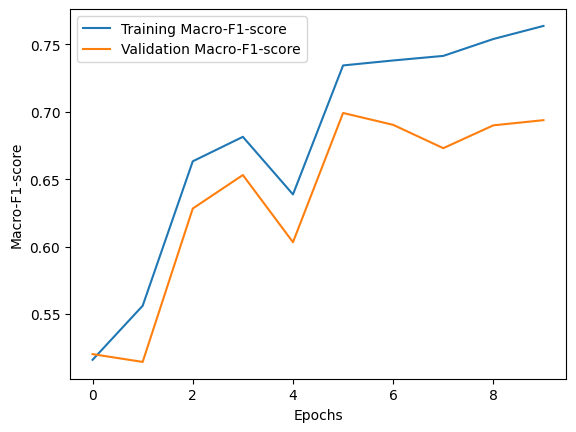

In [21]:
train_f1_scores = []
val_f1_scores = []
for epoch in range(10):
    # Perform one epoch of training
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=True, validation_data=(X_val, y_val))

    # Get predictions for training and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert one-hot encoded labels back to integer labels
    y_train_true = np.argmax(y_train, axis=-1)
    y_val_true = np.argmax(y_val, axis=-1)

    # Calculate F1-score for training and validation data
    train_f1 = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average='macro')
    val_f1 = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average='macro')
    
    # Append F1-score values to lists
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    # Print F1-score for each epoch
    print(f'Epoch {epoch + 1}: Training Macro-F1-score: {train_f1}, Validation Macro-F1-score: {val_f1}')

# Plot F1-score
plt.plot(train_f1_scores, label='Training Macro-F1-score')
plt.plot(val_f1_scores, label='Validation Macro-F1-score')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1-score')
plt.legend()
plt.show()


# GRU

In [26]:
X_train_padded = word_embeddings2  # Assuming padded word embeddings
y_train_padded = labels_padded           # Assuming padded labels

# Split into training and validation sets (85-15 split)
split = int(0.85 * len(X_train_padded))
X_train, X_val = X_train_padded[:split], X_train_padded[split:]
y_train, y_val = y_train_padded[:split], y_train_padded[split:]


# Assuming you have already prepared the data and defined the model

# model
model = tf.keras.Sequential([
    tf.keras.layers.GRU(units=128, return_sequences=True, input_shape=(78, 100)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Adjust learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, verbose=1)


Epoch 1/10
25/25 [==============================] - 5s 79ms/step - loss: 0.1265 - accuracy: 0.9525 - val_loss: 0.2025 - val_accuracy: 0.9718
Epoch 2/10
25/25 [==============================] - 1s 44ms/step - loss: 0.1492 - accuracy: 0.9706 - val_loss: 0.1267 - val_accuracy: 0.9736
Epoch 3/10
25/25 [==============================] - 1s 50ms/step - loss: 0.1059 - accuracy: 0.9737 - val_loss: 0.1022 - val_accuracy: 0.9736
Epoch 4/10
25/25 [==============================] - 1s 43ms/step - loss: 0.0952 - accuracy: 0.9738 - val_loss: 0.0921 - val_accuracy: 0.9736
Epoch 5/10
25/25 [==============================] - 1s 43ms/step - loss: 0.0876 - accuracy: 0.9743 - val_loss: 0.0869 - val_accuracy: 0.9741
Epoch 6/10
25/25 [==============================] - 1s 44ms/step - loss: 0.0818 - accuracy: 0.9741 - val_loss: 0.0808 - val_accuracy: 0.9741
Epoch 7/10
25/25 [==============================] - 1s 48ms/step - loss: 0.0770 - accuracy: 0.9743 - val_loss: 0.0767 - val_accuracy: 0.9743
Epoch 8/10
25

5/5 [==============================] - 0s 18ms/step
Epoch 1: Training Macro-F1-score: 0.3953444912593072, Validation Macro-F1-score: 0.3878131298816652
5/5 [==============================] - 0s 18ms/step
Epoch 2: Training Macro-F1-score: 0.40926845838863235, Validation Macro-F1-score: 0.39846681873379164
5/5 [==============================] - 0s 17ms/step
Epoch 3: Training Macro-F1-score: 0.45855178710174166, Validation Macro-F1-score: 0.4569518152632717
5/5 [==============================] - 0s 15ms/step
Epoch 4: Training Macro-F1-score: 0.48463094033646864, Validation Macro-F1-score: 0.4809693950152117
5/5 [==============================] - 0s 16ms/step
Epoch 5: Training Macro-F1-score: 0.5216605517040119, Validation Macro-F1-score: 0.528283562127093
5/5 [==============================] - 0s 15ms/step
Epoch 6: Training Macro-F1-score: 0.5437225389399886, Validation Macro-F1-score: 0.5262739171052524
5/5 [==============================] - 0s 15ms/step
Epoch 7: Training Macro-F1-score:

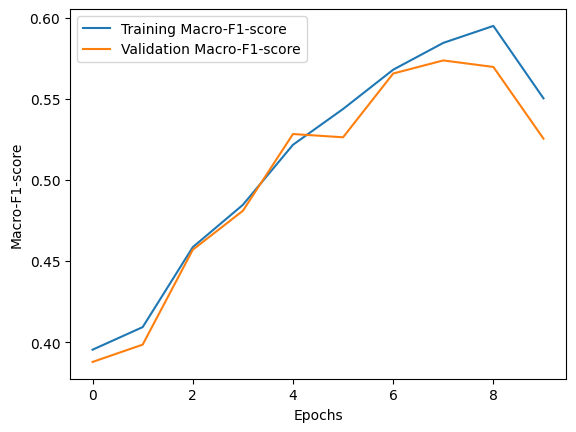

In [27]:
train_f1_scores = []
val_f1_scores = []
for epoch in range(10):
    # Perform one epoch of training
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=True, validation_data=(X_val, y_val))

    # Get predictions for training and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert one-hot encoded labels back to integer labels
    y_train_true = np.argmax(y_train, axis=-1)
    y_val_true = np.argmax(y_val, axis=-1)

    # Calculate F1-score for training and validation data
    train_f1 = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average='macro')
    val_f1 = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average='macro')
    
    # Append F1-score values to lists
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    # Print F1-score for each epoch
    print(f'Epoch {epoch + 1}: Training Macro-F1-score: {train_f1}, Validation Macro-F1-score: {val_f1}')

# Plot F1-score
plt.plot(train_f1_scores, label='Training Macro-F1-score')
plt.plot(val_f1_scores, label='Validation Macro-F1-score')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1-score')
plt.legend()
plt.show()


# LSTM

In [28]:
X_train_padded = word_embeddings2  # Assuming padded word embeddings
y_train_padded = labels_padded           # Assuming padded labels

# Split into training and validation sets (85-15 split)
split = int(0.85 * len(X_train_padded))
X_train, X_val = X_train_padded[:split], X_train_padded[split:]
y_train, y_val = y_train_padded[:split], y_train_padded[split:]


# Assuming you have already prepared the data and defined the model

# model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=128, return_sequences=True, input_shape=(78, 100)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Adjust learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, verbose=1)


Epoch 1/10
25/25 [==============================] - 4s 72ms/step - loss: 0.1403 - accuracy: 0.9399 - val_loss: 0.1456 - val_accuracy: 0.9735
Epoch 2/10
25/25 [==============================] - 1s 47ms/step - loss: 0.1358 - accuracy: 0.9734 - val_loss: 0.1206 - val_accuracy: 0.9736
Epoch 3/10
25/25 [==============================] - 1s 58ms/step - loss: 0.1076 - accuracy: 0.9736 - val_loss: 0.0977 - val_accuracy: 0.9737
Epoch 4/10
25/25 [==============================] - 1s 57ms/step - loss: 0.0942 - accuracy: 0.9737 - val_loss: 0.0981 - val_accuracy: 0.9735
Epoch 5/10
25/25 [==============================] - 1s 56ms/step - loss: 0.0883 - accuracy: 0.9740 - val_loss: 0.0847 - val_accuracy: 0.9734
Epoch 6/10
25/25 [==============================] - 1s 55ms/step - loss: 0.0816 - accuracy: 0.9742 - val_loss: 0.0822 - val_accuracy: 0.9739
Epoch 7/10
25/25 [==============================] - 2s 65ms/step - loss: 0.0773 - accuracy: 0.9744 - val_loss: 0.0781 - val_accuracy: 0.9740
Epoch 8/10
25

5/5 [==============================] - 0s 19ms/step
Epoch 1: Training Macro-F1-score: 0.38705100102717643, Validation Macro-F1-score: 0.3751609634931529
5/5 [==============================] - 0s 19ms/step
Epoch 2: Training Macro-F1-score: 0.39986799068675466, Validation Macro-F1-score: 0.3859417572953508
5/5 [==============================] - 0s 19ms/step
Epoch 3: Training Macro-F1-score: 0.4037692077132981, Validation Macro-F1-score: 0.3913942698617688
5/5 [==============================] - 0s 21ms/step
Epoch 4: Training Macro-F1-score: 0.4077482483884147, Validation Macro-F1-score: 0.39378251589861274
5/5 [==============================] - 0s 21ms/step
Epoch 5: Training Macro-F1-score: 0.4264952968438307, Validation Macro-F1-score: 0.41749845379246137
5/5 [==============================] - 0s 20ms/step
Epoch 6: Training Macro-F1-score: 0.45357846475583097, Validation Macro-F1-score: 0.45539751158354513
5/5 [==============================] - 0s 21ms/step
Epoch 7: Training Macro-F1-sco

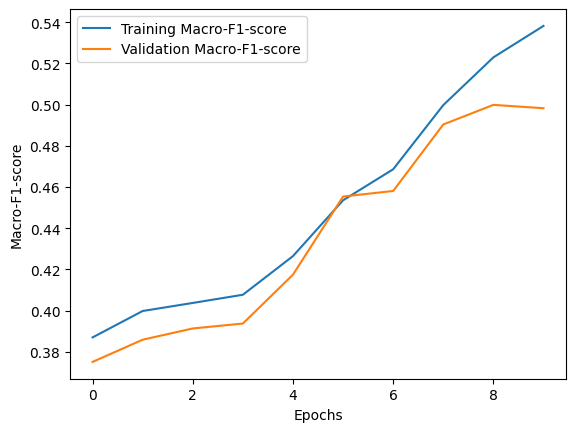

In [29]:
train_f1_scores = []
val_f1_scores = []
for epoch in range(10):
    # Perform one epoch of training
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=True, validation_data=(X_val, y_val))

    # Get predictions for training and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert one-hot encoded labels back to integer labels
    y_train_true = np.argmax(y_train, axis=-1)
    y_val_true = np.argmax(y_val, axis=-1)

    # Calculate F1-score for training and validation data
    train_f1 = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average='macro')
    val_f1 = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average='macro')
    
    # Append F1-score values to lists
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    # Print F1-score for each epoch
    print(f'Epoch {epoch + 1}: Training Macro-F1-score: {train_f1}, Validation Macro-F1-score: {val_f1}')

# Plot F1-score
plt.plot(train_f1_scores, label='Training Macro-F1-score')
plt.plot(val_f1_scores, label='Validation Macro-F1-score')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1-score')
plt.legend()
plt.show()



## Test data

In [41]:
def load_data(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

data2 = load_data("Dataset2-AspectTermExtraction_test.json")

texts2 = [i['text'] for i in data2]
labels = [i['labels'] for i in data2]
words2 = [sentence.split() for sentence in texts2]


In [42]:
def load_glove_embeddings(glove_file, embedding_dim):
    """Loads pre-trained GloVe word embeddings from a file.
    Returns: dict: A dictionary mapping words to their corresponding embedding vectors.
             np.ndarray: An embedding matrix with rows representing words and columns representing dimensions.
    """
    embeddings_index = {}
    embedding_matrix = np.zeros((len(word_to_id) + 1, embedding_dim))  # Add 1 for padding

    with open(glove_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    for word, index in word_to_id.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
        else:
            embedding_matrix[index] = np.zeros(embedding_dim)

    return embeddings_index, embedding_matrix

# Replace with your downloaded GloVe file path and desired dimensionality
glove_file = "glove.6B.100d.txt"  # Example: glove.6B.100d.txt
embedding_dim = 100

# Create a dictionary mapping words to their unique IDs (optional for vectorization)
word_to_id = {}
next_id = 1
for sentence in words2:  # Iterate through sentences in the nested list
    for word in sentence:
        if word not in word_to_id:
            word_to_id[word] = next_id
            next_id += 1

# Load the GloVe embeddings
embeddings_index, embedding_matrix = load_glove_embeddings(glove_file, embedding_dim)


In [44]:
# find the maxlength of the sentence
max_length = max([len(i) for i in words2])
max_length

71

In [45]:
# Vectorization of words
word_embeddings2 = []
for sentence in words2:
    sentence_embedding = []
    for word in sentence:
        vector = embeddings_index.get(word)
        if vector is not None:
            sentence_embedding.append(vector)
        else:
            sentence_embedding.append(np.zeros(100)) # dimension of the glove file used.
    word_embeddings2.append(sentence_embedding)

In [46]:
for sentence in word_embeddings2:
    sentence_length = len(sentence)
    if sentence_length < 78: #max length of sentence = 70
        while len(sentence) < 78:
            sentence.append(np.zeros(100))     

# padding to convert into (9435, 70, 100)  from (9435, variable_length, 70)           
for i in range(len(word_embeddings2)):
    word_embeddings2[i] = np.array(word_embeddings2[i])
word_embeddings2 = np.array(word_embeddings2)
word_embeddings2.shape 

(328, 78, 100)

In [47]:
flat_labels = [label for sublist in labels for label in sublist]

# Find unique labels
unique_labels = set(flat_labels)

print(unique_labels)

label2idx = {label: idx for idx, label in enumerate(unique_labels)}
labels_idx = [[label2idx[label] for label in sublist] for sublist in labels]

# One-hot encode labels
num_classes = len(unique_labels)
one_hot_labels = [to_categorical(sublist, num_classes=num_classes) for sublist in labels_idx]

{'O', 'I', 'B'}


In [48]:
labels_padded = np.zeros((np.array(one_hot_labels).shape[0], 78, 3))  # Initialize padded array

# Iterate over each sentence in one_hot_labels and pad to length 70
for i, sentence in enumerate(one_hot_labels):
    padded_sentence = np.pad(sentence, ((0, 78 - len(sentence)), (0, 0)), mode='constant', constant_values=0)
    labels_padded[i] = padded_sentence
labels_padded.shape

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18108\1278505847.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels_padded = np.zeros((np.array(one_hot_labels).shape[0], 78, 3))  # Initialize padded array


(328, 78, 3)

In [49]:
X_test_padded = word_embeddings2
y_test_padded = labels_padded

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test_padded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

11/11 [==============================] - 0s 22ms/step - loss: 0.0617 - accuracy: 0.9769
Test Loss: 0.061659399420022964
Test Accuracy: 0.976860523223877
